# Predicting Droughts with Meteorological Data
## training the multioutput classifier for the full task

In [1]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.auto import tqdm
from datetime import datetime
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

from projectUtils import *


## Load our saved Data
We can index to get submatrices for less previous observations

In [4]:
def np_load(filename):
    path = ''
    return np.load(path + filename + '.npy', allow_pickle=True)

X_train = np_load('X_train_14wvar')
y_train = np_load('y_train_14wvar')
X_valid = np_load('X_valid')
y_valid = np_load('y_valid_14wvar')

In [5]:
X_valid.shape

(8748, 3810)

In [3]:
# convert to multiclass
y_train = round_and_intify(y_train)
y_valid = round_and_intify(y_valid)

In [4]:
y_valid.dtype

dtype('int32')

## Ordinal classification with aggregated binary classifiers
https://stackoverflow.com/questions/57561189/multi-class-multi-label-ordinal-classification-with-sklearn


## multioutput gridSearch

training is impractically slow for anything but lbfgs, sag or saga

In [5]:
#initialize base classifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import mean_absolute_error, make_scorer, f1_score

base_clf = LogisticRegression()
ord_clf = OrdinalClassifier(base_clf, mean_absolute_error)
multi = MultiOutputClassifier(ord_clf)


multi.get_params()

{'estimator__base_estimator__C': 1.0,
 'estimator__base_estimator__class_weight': None,
 'estimator__base_estimator__dual': False,
 'estimator__base_estimator__fit_intercept': True,
 'estimator__base_estimator__intercept_scaling': 1,
 'estimator__base_estimator__l1_ratio': None,
 'estimator__base_estimator__max_iter': 100,
 'estimator__base_estimator__multi_class': 'auto',
 'estimator__base_estimator__n_jobs': None,
 'estimator__base_estimator__penalty': 'l2',
 'estimator__base_estimator__random_state': None,
 'estimator__base_estimator__solver': 'lbfgs',
 'estimator__base_estimator__tol': 0.0001,
 'estimator__base_estimator__verbose': 0,
 'estimator__base_estimator__warm_start': False,
 'estimator__base_estimator': LogisticRegression(),
 'estimator__loss': <function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'estimator': OrdinalClassifier(base_estimator=LogisticRegression(),
                   loss=<function

In [6]:
def transform_param(grid):
    #utility to rename keys for chained estimator
    prefix = 'estimator__base_estimator__'
    return {prefix + k: grid[k] for k in grid.keys()}

In [7]:
from sklearn.utils.random import sample_without_replacement as sample

#train and validate on a subset to save time
train_num = int(y_train.shape[0] / 2)
indices = sample(y_train.shape[0], train_num)

X_t_s = X_train[indices, :]
y_t_s = y_train[indices, :]

#train on a subset to save time
valid_num = int(y_valid.shape[0] / 2)
val_indices = sample(y_valid.shape[0], valid_num)

X_v_s = X_valid[val_indices, :]
y_v_s = y_valid[val_indices, :]

In [8]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

scorer = {'mae': make_scorer(mean_absolute_error),
          'f1': make_scorer(macro_f1)}

X = np.vstack((X_t_s, X_v_s))
y = np.vstack((y_t_s, y_v_s))

indexer = np.ones(X.shape[0], dtype=np.int8)
indexer[ :X_t_s.shape[0] + 1] *= -1
ps = PredefinedSplit(indexer)

def searchMulti(params, iters, solv, multi_jobs, X, y, X_v, y_v, name):
    
    base_clf = LogisticRegression(solver=solv, max_iter=iters)
    ord_clf = OrdinalClassifier(base_clf, mean_absolute_error)
    multi = MultiOutputClassifier(ord_clf, n_jobs = multi_jobs)
                                  
    tic = time.perf_counter()

    gridSearch = GridSearchCV(multi, transform_param(params), 
                              scoring=scorer,
                              n_jobs=-1,
                              refit='mae',
                              verbose=3,
                              cv=ps) 

    gridSearch.fit(X, y)
    save_model(gridSearch, name)

    #print time
    timer(tic)
    
    #evaluate
    y_pred = gridSearch.predict(X_v)
    summarize(y_v, y_pred)
    
    return gridSearch



## LBGFS solver with l2 penalty

In [ ]:
param_grid = {'C': [0.5,1.0,5.0],
             'penalty': ['l2']}

grid1 = searchMulti(param_grid, 'lbgfs', 200, X, y, X_v_s, y_v_s, 'lbgfs-l2')

## Default parameters, no penalty, lbgfs solver

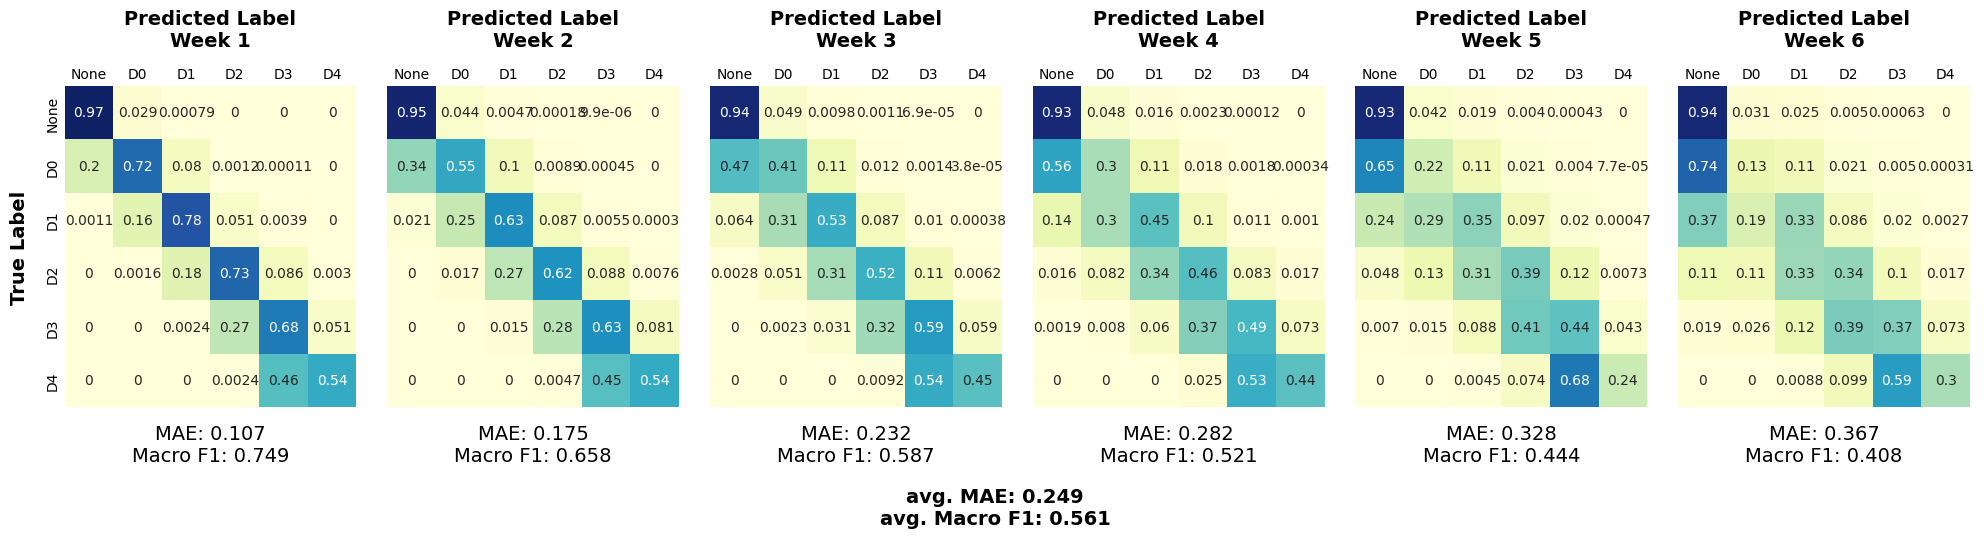

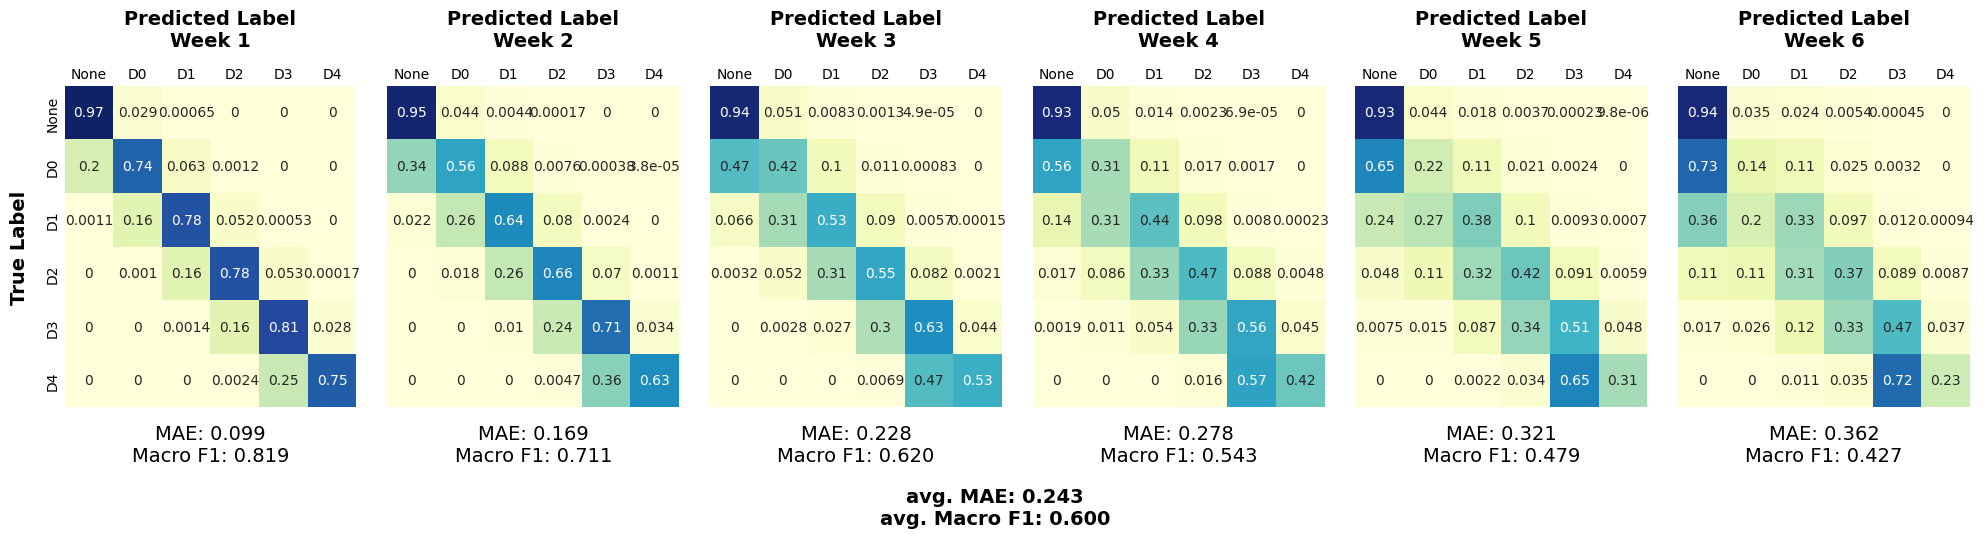

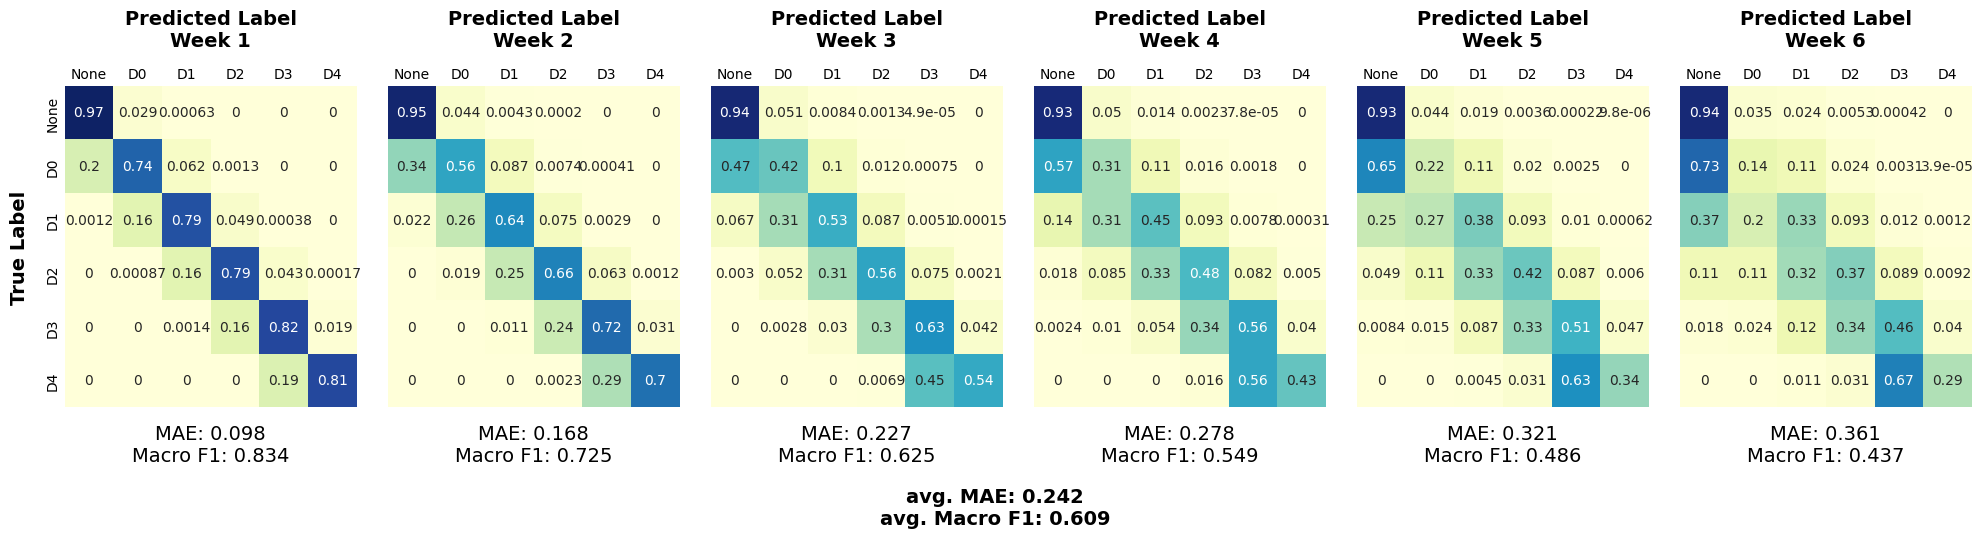

In [9]:
for itr in [100, 250, 500]:
    base_clf = LogisticRegression(solver=SOLVER, max_iter=itr)
    ord_clf = OrdinalClassifier(base_clf, mean_absolute_error)
    multi = MultiOutputClassifier(ord_clf, n_jobs = -1)

    multi.fit(X_train, y_train)
    save_model(multi, 'default-params-' + str(itr) + 'itr')
    
    summarize(y_valid, multi.predict(X_valid))

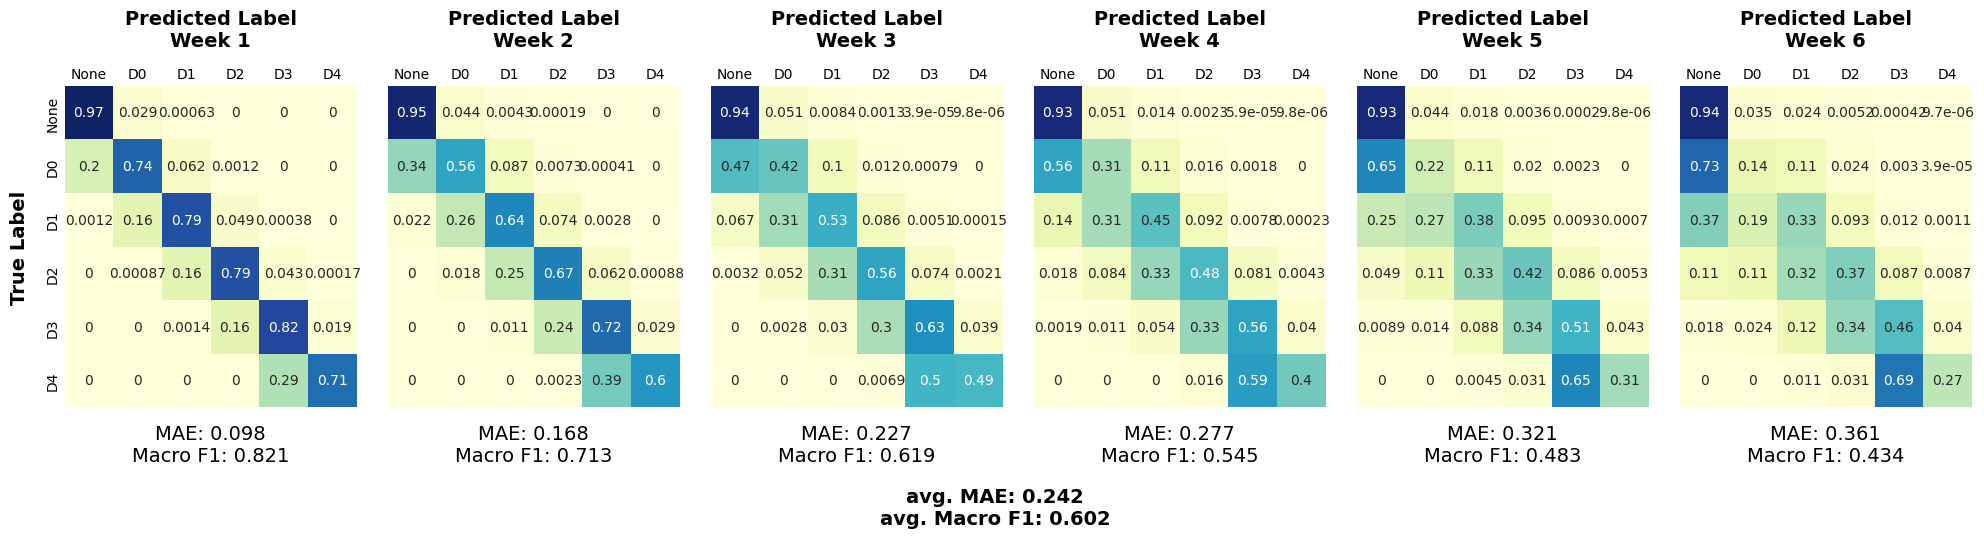

In [26]:
for itr in [1000]:
    base_clf = LogisticRegression(solver=SOLVER, max_iter=itr)
    ord_clf = OrdinalClassifier(base_clf, mean_absolute_error)
    multi = MultiOutputClassifier(ord_clf, n_jobs = -1)

    multi.fit(X_train, y_train)
    save_model(multi, 'default-params-' + str(itr) + 'itr')
    
    summarize(y_valid, multi.predict(X_valid))

In [2]:
itrs = [100, 250, 500, 1000]
maes = [0.249, 0.243, 0.242, 0.242]
f1s = [0.561, 0.6, 0.609, 0.602]

In [3]:
from matplotlib.pyplot import figure

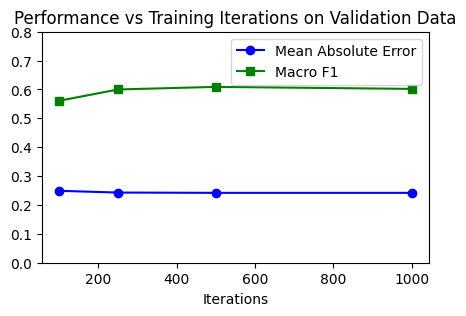

In [14]:
plt.figure(figsize=(5,3)) 
plt.plot(itrs, maes, 'b', marker = 'o', label='Mean Absolute Error')
plt.plot(itrs, f1s, 'g', marker = 's', label='Macro F1')
plt.ylim((0, 0.8))
plt.xlabel('Iterations')
plt.title('Performance vs Training Iterations on Validation Data')
plt.legend()
plt.show()

## SAGA solver with elasticnet

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Elapsed time: 83 minutes, 4 seconds


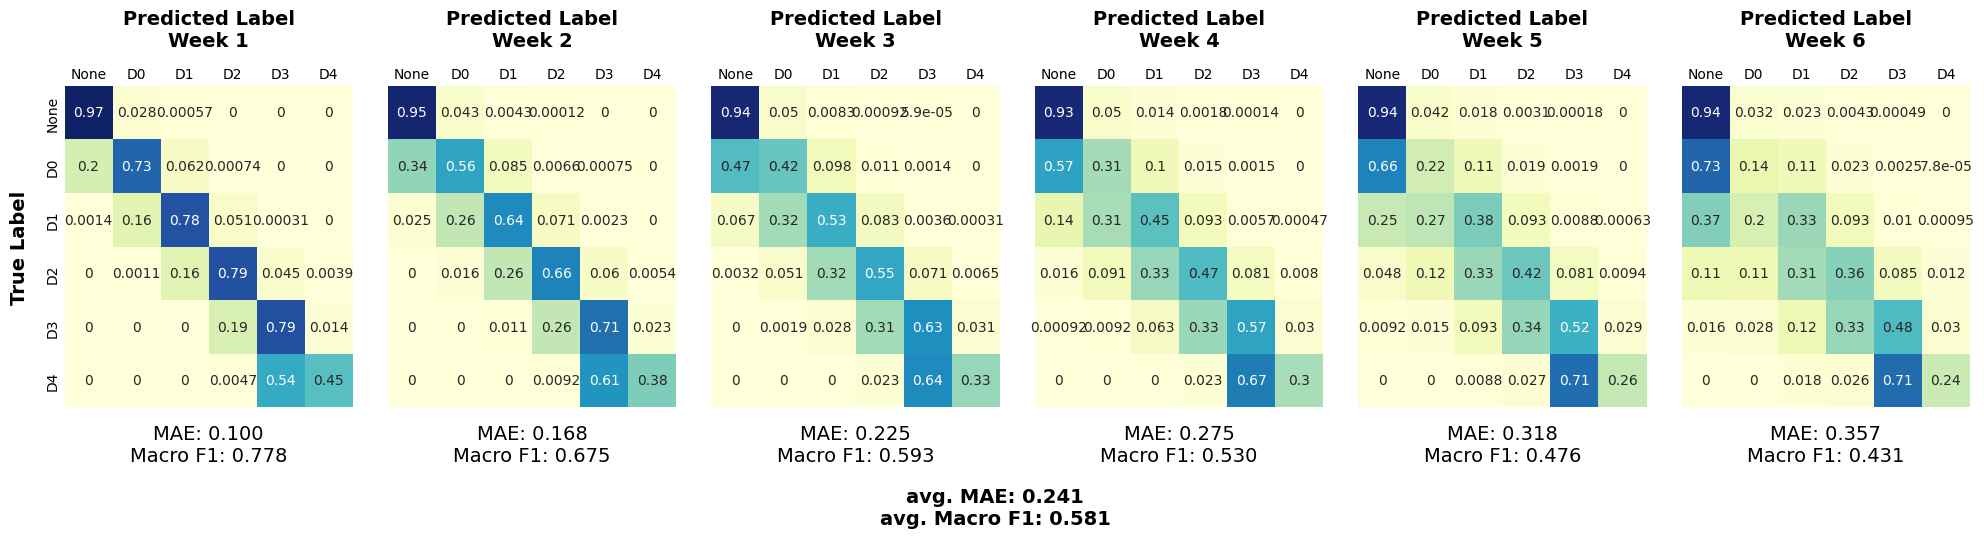

[CV 1/1] END estimator__base_estimator__C=1.0, estimator__base_estimator__l1_ratio=0.5, estimator__base_estimator__penalty=elasticnet; f1: (test=0.572) mae: (test=0.242) total time=37.6min


In [9]:
param_grid = {'C': [1.0],
             'penalty': ['elasticnet'],
             'l1_ratio':[0.5]}

grid2 = searchMulti(param_grid, 250, 'saga', -1, X, y, X_v_s, y_v_s, 'saga-search')

In [13]:
grid2.best_params_

{'estimator__base_estimator__C': 0.01,
 'estimator__base_estimator__l1_ratio': 1.0,
 'estimator__base_estimator__penalty': 'elasticnet'}

# examining results

In [14]:
res = pd.DataFrame.from_dict(grid2.cv_results_)

In [18]:
res = res.sort_values(by=['mean_test_f1'],ascending=False)


In [19]:
res.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_estimator__base_estimator__C',
       'param_estimator__base_estimator__l1_ratio',
       'param_estimator__base_estimator__penalty', 'params', 'split0_test_mae',
       'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_f1',
       'mean_test_f1', 'std_test_f1', 'rank_test_f1'],
      dtype='object')

In [25]:
res['mean_test_f1']

12    0.514500
8     0.514370
13    0.514294
9     0.514285
10    0.514273
11    0.514255
14    0.514246
15    0.514198
5     0.513236
4     0.512363
6     0.511411
7     0.508941
0     0.490125
1     0.486345
2     0.482998
3     0.476696
Name: mean_test_f1, dtype: float64